# 基于K线形态锤子线的趋势跟踪策略

---

### 1.基本原理

1.1 K线部位定义：  
    实体：某一根K线开盘价和收盘价之间部分;  
    上影线：某一根K线最高价到实体上端的部分;  
    下影线：某一根K线最低价到实体下端的部分;

1.2 锤子线定义  
   实体处于整个价格区间上端，实体颜色本身不影响;  
   下影线长度至少达到实体高度的2倍;  
   上影线很短;

1.3 策略原理  
在下跌过程中，当某一日出现锤子线，意味着当天行情先继续下跌后出现大幅反弹，行情可能由此反转; 
由此以观察期均线识别趋势下跌，以下跌趋势中出现锤子线作为开仓信号;  
采用移动止损方式进行止损构建此策略;

1.4 止损条件  
当天最低价 < max(均价-观察期内一定倍数的标准差，开仓价-开仓时标准差）;

<img src= "http://i1.bvimg.com/598810/8a06968def2dfb17.png" alt="锤子线" width="45%" align="left" border="4">

1.5 形态要点：    
在出现锤头线（锤子线）之前，股价需经过一段时间的下跌后，处于下跌趋势中，此时出现此形态才具有参考意义；  
锤头实体越小，下影线越长，止跌作用就越明显，参考价值越大；

## 2.策略回测结果

In [1]:
%matplotlib inline

## 3.策略实现

### 3.1 收集并计算所需数据

In [2]:
import pandas as pd
import numpy as np
import tushare as ts
ts.set_token('5f48e84b07f35508e04ba8c8da76e810ca06de2c29b5d1e9cca19f60')

In [3]:
code = '002398'         # 股票代码
body_size = 0.03        # 表示锤子实体大小上限，基准为当日开盘价，实体不能太大，波动范围限制在3%；
head_size = 0.5         # 表示锤子上影线长度上限，基准为下影线长度，上影线要短一点，不能超过下影线的的一半；
tail_size = 2           # 表示下影线与实体大小比值，下影线要大于实体两倍；
length = 10             # 表示观察期时间长短；
stoplose_trigger = 1    # 表示当价格偏离均线满足几倍标准差时止损

In [4]:
# data = ts.get_h_data(code, '2010-01-01', '2019-03-01')

pro = ts.pro_api()

data = pro.daily(ts_code='002398.SZ', start_date='20150101', end_date='20190418')

In [5]:
data.sort_index(ascending=True, inplace=True)

In [6]:
data

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002398.SZ,20190418,7.26,7.78,7.21,7.69,7.22,0.47,6.5097,287009.58,217253.4780
1,002398.SZ,20190417,7.12,7.31,7.10,7.22,7.12,0.10,1.4045,126990.93,91596.8300
2,002398.SZ,20190416,6.93,7.14,6.86,7.12,6.97,0.15,2.1521,151544.58,106488.4560
3,002398.SZ,20190415,7.29,7.44,6.95,6.97,7.12,-0.15,-2.1067,143345.78,102879.7510
4,002398.SZ,20190412,7.34,7.39,7.00,7.12,7.34,-0.22,-2.9973,186489.12,133998.4730
5,002398.SZ,20190411,7.68,7.88,7.34,7.34,7.28,0.06,0.8242,312580.13,237561.9810
6,002398.SZ,20190410,7.01,7.50,6.75,7.28,6.93,0.35,5.0505,276277.06,198471.9460
7,002398.SZ,20190409,7.07,7.20,6.91,6.93,7.26,-0.33,-4.5455,243634.32,171919.3760
8,002398.SZ,20190408,6.88,7.53,6.88,7.26,6.96,0.30,4.3103,380562.10,270536.1900
9,002398.SZ,20190404,6.90,7.14,6.75,6.96,6.71,0.25,3.7258,337625.62,234684.7520


In [7]:
data.reset_index(inplace=True)        #把索引设置成为默认；为了后面交易策略逻辑循环更方便一些；

In [8]:
data.head()

,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,0,002398.SZ,20190418,7.26,7.78,7.21,7.69,7.22,0.47,6.5097,287009.58,217253.478
1,1,002398.SZ,20190417,7.12,7.31,7.10,7.22,7.12,0.10,1.4045,126990.93,91596.830
2,2,002398.SZ,20190416,6.93,7.14,6.86,7.12,6.97,0.15,2.1521,151544.58,106488.456
3,3,002398.SZ,20190415,7.29,7.44,6.95,6.97,7.12,-0.15,-2.1067,143345.78,102879.751
4,4,002398.SZ,20190412,7.34,7.39,7.00,7.12,7.34,-0.22,-2.9973,186489.12,133998.473


In [9]:
data['pct_change'] = data['close'].pct_change()

In [10]:
data['ma'] = data['close'].rolling(length).mean()

In [11]:
data['std'] = data['close'].rolling(length).std()

In [12]:
# del data['volume']
# del data['amount']

In [13]:
data.tail()

,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,pct_change,ma,std
920,920,002398.SZ,20150109,15.75,15.99,15.66,15.68,15.75,-0.07,-0.44,27788.38,44062.6453,-0.006966,16.159,0.478457
921,921,002398.SZ,20150108,16.18,16.35,15.75,15.75,16.18,-0.43,-2.66,42587.68,67970.9088,0.004464,16.025,0.362284
922,922,002398.SZ,20150107,16.34,16.39,16.06,16.18,16.49,-0.31,-1.88,34807.99,56423.9617,0.027302,15.956,0.222021
923,923,002398.SZ,20150106,16.00,16.71,15.85,16.49,16.13,0.36,2.23,80328.11,130551.3851,0.019159,15.976,0.261032
924,924,002398.SZ,20150105,15.95,16.27,15.62,16.13,15.95,0.18,1.13,23295.28,37235.4085,-0.021831,16.004,0.261032


由于实盘中当天的日线级别参考指标未实现，因此使用昨日参考指标指导当日交易,避免未来函数；

In [14]:
data['yes_ma'] = data['ma'].shift(1)          #昨天的mean和昨天的std；

In [15]:
data['yes_std'] = data['std'].shift(1)

### 3.2 识别锤子形态

计算实体，上影线，下影线

In [16]:
data['body'] = abs(data['open'] - data['close'])                   #计算K线实体；

In [17]:
data['head'] = data['high'] - data[['open', 'close']].max(axis = 1 )       #计算上影线，按行计算

In [18]:
data['tail'] = data[['open', 'close']].min(axis=1) - data['low']        #计算下影线

In [19]:
data.head()

,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,pct_change,ma,std,yes_ma,yes_std,body,head,tail
0,0,002398.SZ,20190418,7.26,7.78,7.21,7.69,7.22,0.47,6.5097,287009.58,217253.478,NaN,NaN,NaN,NaN,NaN,0.43,0.09,0.05
1,1,002398.SZ,20190417,7.12,7.31,7.10,7.22,7.12,0.10,1.4045,126990.93,91596.830,-0.061118,NaN,NaN,NaN,NaN,0.10,0.09,0.02
2,2,002398.SZ,20190416,6.93,7.14,6.86,7.12,6.97,0.15,2.1521,151544.58,106488.456,-0.013850,NaN,NaN,NaN,NaN,0.19,0.02,0.07
3,3,002398.SZ,20190415,7.29,7.44,6.95,6.97,7.12,-0.15,-2.1067,143345.78,102879.751,-0.021067,NaN,NaN,NaN,NaN,0.32,0.15,0.02
4,4,002398.SZ,20190412,7.34,7.39,7.00,7.12,7.34,-0.22,-2.9973,186489.12,133998.473,0.021521,NaN,NaN,NaN,NaN,0.22,0.05,0.12


判断K线各部分是否符合锤子线要求

In [20]:
data['body_cond'] = np.where(data['body']/data['open'] < body_size, 1, 0)     #实体的大小比开盘价要小于3%，K线实体不能太大；

In [21]:
data['head_cond'] = np.where(data['tail']==0, False, data['head'] / data['tail'] < head_size)   #上影线不能比下影线的一半长；
# 当尾部长度为0，为防止判断除法报错，两步判断；
# data['head_cond'] = np.where(data['head']/data['tail'] < head_size, 1, 0)   有可能tail = 0 

In [22]:
data['tail_cond'] = np.where(data['body']==0, True, (data['tail']/data['body']) > tail_size)    #下影线要比实体的两倍更长才满足条件；

In [23]:
data.head()

,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,...,ma,std,yes_ma,yes_std,body,head,tail,body_cond,head_cond,tail_cond
0,0,002398.SZ,20190418,7.26,7.78,7.21,7.69,7.22,0.47,6.5097,...,NaN,NaN,NaN,NaN,0.43,0.09,0.05,0,False,False
1,1,002398.SZ,20190417,7.12,7.31,7.10,7.22,7.12,0.10,1.4045,...,NaN,NaN,NaN,NaN,0.10,0.09,0.02,1,False,False
2,2,002398.SZ,20190416,6.93,7.14,6.86,7.12,6.97,0.15,2.1521,...,NaN,NaN,NaN,NaN,0.19,0.02,0.07,1,True,False
3,3,002398.SZ,20190415,7.29,7.44,6.95,6.97,7.12,-0.15,-2.1067,...,NaN,NaN,NaN,NaN,0.32,0.15,0.02,0,False,False
4,4,002398.SZ,20190412,7.34,7.39,7.00,7.12,7.34,-0.22,-2.9973,...,NaN,NaN,NaN,NaN,0.22,0.05,0.12,1,True,False


判断K线形态是否符合锤子线

In [24]:
data['hammer'] = data[['head_cond', 'body_cond', 'tail_cond']].all(axis=1)      #同时满足以上三个条件才是锤子K线；

In [25]:
data['hammer'].tail()

920    False
921    False
922    False
923    False
924    False
Name: hammer, dtype: bool

In [26]:
data[data['hammer']].tail(10)

,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,...,std,yes_ma,yes_std,body,head,tail,body_cond,head_cond,tail_cond,hammer
816,816,002398.SZ,20150713,18.50,18.50,17.80,18.50,16.82,1.68,9.99,...,0.903460,18.038,0.982274,0.00,0.00,0.70,1,True,True,True
823,823,002398.SZ,20150604,27.00,27.40,24.19,26.47,26.87,-0.40,-1.49,...,4.191513,20.449,4.060672,0.53,0.40,2.28,1,True,True,True
840,840,002398.SZ,20150512,24.79,24.96,24.01,24.54,24.64,-0.10,-0.41,...,1.997266,28.213,2.149910,0.25,0.17,0.53,1,True,True,True
843,843,002398.SZ,20150507,23.17,23.17,21.90,22.96,23.30,-0.34,-1.46,...,1.850958,26.407,1.976068,0.21,0.00,1.06,1,True,True,True
847,847,002398.SZ,20150430,24.27,24.47,23.78,24.22,24.27,-0.05,-0.21,...,1.070992,24.661,1.166118,0.05,0.20,0.44,1,True,True,True
872,872,002398.SZ,20150325,19.58,19.65,19.14,19.44,19.44,0.00,0.00,...,1.758089,21.987,1.611121,0.14,0.07,0.30,1,True,True,True
880,880,002398.SZ,20150313,18.65,18.84,18.20,18.60,18.49,0.11,0.59,...,0.501549,19.500,0.472511,0.05,0.19,0.40,1,True,True,True
885,885,002398.SZ,20150306,18.03,18.23,17.60,18.23,18.05,0.18,1.00,...,0.415002,18.961,0.462684,0.20,0.00,0.43,1,True,True,True
893,893,002398.SZ,20150217,17.19,17.19,16.91,17.10,17.19,-0.09,-0.52,...,0.545405,17.728,0.598866,0.09,0.00,0.19,1,True,True,True
904,904,002398.SZ,20150202,16.73,16.75,16.51,16.70,16.79,-0.09,-0.54,...,0.419052,16.725,0.449697,0.03,0.02,0.19,1,True,True,True


由于实盘中当天的日线级别参考指标未实现，因此应根据昨日是否满足锤子形态要求作为开仓信号

In [27]:
 data['yes_hammer'] = data['hammer'].shift(1)

### 3.3 编写交易逻辑——循环法

In [28]:
flag = 0    # 持仓记录，1代码有仓位，0代表空仓；
for i in range(2*length, len(data)):     #从20天开始计算，因为前期数据无效；
    # 如果已持仓，判断是否止损
    if flag == 1:
        stoplose_price = max(data.loc[i, 'yes_ma'] - stoplose_trigger*data.loc[i, 'yes_std'],
                             long_open_price-long_open_delta) 
        # 当天价格低于止损价，则进行止损，一个是移动止损，一个是开仓时候的开仓和开仓价-1倍标准差；
        if data.loc[i, 'low'] < stoplose_price:  #接下来要做的都是止损的操作；
            flag = 0
            data.loc[i, 'return'] = min(data.loc[i, 'open'], stoplose_price)/data.loc[i-1, 'close'] - 1 
            #计算清盘当天的收益；取min是因为，如果当天开盘价就小于了止损价，那么我们就要以开盘价就止损；
            #不然会导致策略收益高估；
            #收益计算时要除以前一天的收盘价；
#             data.loc[i, 'return'] = stoplose_price/data.loc[i-1, 'close'] - 1 
            
            data.loc[i, 'trade_mark'] = -10    # 表示当天持仓并进行平仓，记录自己当天交易操作，平仓：-10；
            #开仓是10；持仓为1，方便查阅；
        
        # 如果不满足止损条件，则继续持仓
        else:
            data.loc[i, 'return'] = data.loc[i, 'close']/data.loc[i-1, 'close'] - 1
            data.loc[i, 'trade_mark'] = 1    # 表示当天持仓



    # 如果未持仓，判断是否进行开仓
    else:
        # 判断是否为下降趋势，平均重心是下降的；锤子线开仓要满足形态和下降趋势；
        if data.loc[i-length, 'yes_ma'] > data.loc[i, 'yes_ma']:
            # 判断是否符合锤子形态
            if data.loc[i, 'yes_hammer']:
                # 更改持仓标记
                flag = 1
                # 记录开仓时开仓价格及标准差:是为了做固定止损；
                long_open_price = data.loc[i, 'open']
                long_open_delta = data.loc[i, 'yes_std']
                # 计算当天收益率
                data.loc[i, 'return'] = data.loc[i, 'close']/data.loc[i, 'open'] - 1  #以产生信号之后的第二天开盘价开仓；
                data.loc[i, 'trade_mark'] = 10    # 表示当天开仓
                # 当天开仓之后不进行平仓判断

In [29]:
data.tail(50)

,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,...,body,head,tail,body_cond,head_cond,tail_cond,hammer,yes_hammer,return,trade_mark
875,875,002398.SZ,20150320,19.68,19.94,19.48,19.78,19.71,0.07,0.36,...,0.10,0.16,0.20,1,False,False,False,False,-0.011000,1.0
876,876,002398.SZ,20150319,18.97,19.84,18.88,19.71,19.04,0.67,3.52,...,0.74,0.13,0.09,0,False,False,False,False,-0.040950,-10.0
877,877,002398.SZ,20150318,18.75,19.08,18.70,19.04,18.72,0.32,1.71,...,0.29,0.04,0.05,1,False,False,False,False,NaN,NaN
878,878,002398.SZ,20150317,18.92,19.00,18.53,18.72,18.92,-0.20,-1.06,...,0.20,0.08,0.19,1,True,False,False,False,NaN,NaN
879,879,002398.SZ,20150316,18.69,19.01,18.63,18.92,18.60,0.32,1.72,...,0.23,0.09,0.06,1,False,False,False,False,NaN,NaN
880,880,002398.SZ,20150313,18.65,18.84,18.20,18.60,18.49,0.11,0.59,...,0.05,0.19,0.40,1,True,True,True,False,NaN,NaN
881,881,002398.SZ,20150312,19.08,19.13,18.30,18.49,19.13,-0.64,-3.35,...,0.59,0.05,0.19,0,True,False,False,True,-0.030922,10.0
882,882,002398.SZ,20150311,18.58,19.24,18.50,19.13,18.58,0.55,2.96,...,0.55,0.11,0.08,1,False,False,False,False,0.004867,-10.0
883,883,002398.SZ,20150310,18.60,18.92,18.46,18.58,18.64,-0.06,-0.32,...,0.02,0.32,0.12,1,False,True,False,False,NaN,NaN
884,884,002398.SZ,20150309,18.15,18.80,18.00,18.64,18.23,0.41,2.25,...,0.49,0.16,0.15,1,False,False,False,False,NaN,NaN


### 3.4 计算策略收益率

In [30]:
data['return'].fillna(0, inplace=True)                   #对大循环中未处理的：既没有持仓，也不满足开仓条件的日期进行处理，则让这些天的return都等于0；


data['strategy_return'] = (data['return'] + 1).cumprod()
data['stock_return'] = (data['pct_change'] + 1).cumprod()

### 3.5 绘图

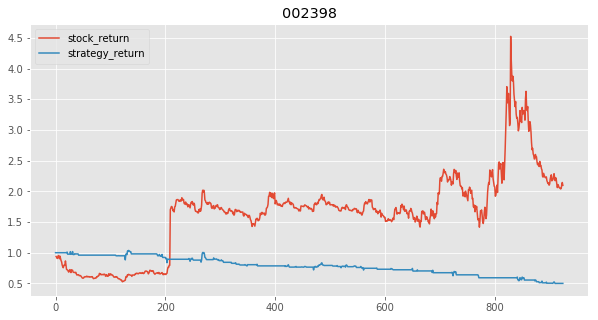

In [32]:
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(data.stock_return)
ax.plot(data.strategy_return)
plt.title(code)
plt.legend()
plt.show()

#### 4. 策略改进和优化思考

1. 考虑成交量的配合：在锤子线后面的一根K线如果放量的话，交易信号更可信；    
2. 考虑跟其他形态的结合，例如锤子线后面紧跟着一根大阳线，交易信号更可信；  
3. 考虑和其他技术指标的结合，配合技术指标一起进行条件选股；

声明：本资料仅供内部学习交流使用，切勿外传。